<a href="https://colab.research.google.com/github/skimaza/jnu/blob/main/mnist_mlp_jeju.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 제주대 딥러닝 특강 Day 1
# Multilayer Perceptron 실습 예제
# MLP를 이용한 MNIST 필기체 숫자 인식
## MNIST dataset: http://yann.lecun.com/exdb/mnist/

# 라이브러리 import
- numpy: number를 다루는 라이브러리(패키지)
- torch: PyTorch 딥러닝 프레임워크 라이브러리
- torchvision: PyTorch로 이미지 데이터를 다루는 라이브러리
- matplotlib: 이미지와 그래프 표시

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

# Colab으로 배정된 가상머신 확인

### 현재 디렉토리(폴더)
### '!'로 시작하는 명령은 가상머신의 명령을 실행하라는 의미

In [2]:
!pwd

/content


### 현재 디렉토리의 내용

In [3]:
!ls -l

total 4
drwxr-xr-x 1 root root 4096 Aug 13 13:35 sample_data


### sample_data directory에는 Google Colab에서 기본으로 제공하는 데이터가 있음
### (이번 특강에서 사용할 데이터는 아님)

In [4]:
!ls sample_data

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


# PyTorch에서 제공하는 공개 데이터셋 라이브러리 사용
transform parameter는 데이터셋에 자동으로 적용할 데이터 변환 기능.  
여기서는 데이터값을 파이토치 Tensor로 바꾸는 기능만 사용.  
데이터의 값을 정규화하거나 일부를 잘라내거나 회전하거나 하는 등의 데이터 augmentation을 지정할 수 있다

In [7]:
transform = transforms.ToTensor()

torchvision에서 import한 datasets 모듈을 이용해서 미리 정의된 MNIST 데이터셋을 다운로드

In [7]:
# choose the training and testing datasets
train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# 다운로드된 디렉토리 확인

In [11]:
!ls

data  mnist_alt.tgz  sample_data


In [12]:
!ls data

MNIST


In [13]:
!ls -l data/MNIST/raw

total 65008
-rw-rw-r-- 1 1000 1000  7840016 Aug 22 21:40 t10k-images-idx3-ubyte
-rw-rw-r-- 1 1000 1000  1648877 Aug 22 21:40 t10k-images-idx3-ubyte.gz
-rw-rw-r-- 1 1000 1000    10008 Aug 22 21:40 t10k-labels-idx1-ubyte
-rw-rw-r-- 1 1000 1000     4542 Aug 22 21:40 t10k-labels-idx1-ubyte.gz
-rw-rw-r-- 1 1000 1000 47040016 Aug 22 21:41 train-images-idx3-ubyte
-rw-rw-r-- 1 1000 1000  9912422 Aug 22 21:41 train-images-idx3-ubyte.gz
-rw-rw-r-- 1 1000 1000    60008 Aug 22 21:40 train-labels-idx1-ubyte
-rw-rw-r-- 1 1000 1000    28881 Aug 22 21:40 train-labels-idx1-ubyte.gz


# 아래 코드는 다운로드가 안 되는 경우를 위한 코드
# 각 라인 앞의 '#'을 지우고 실행

In [ ]:
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1dxPHAbkrdwcG6SuDXtL5M7JANouZ8dsJ' -O mnist_alt.tgz
# !tar xzf mnist_alt.tgz
# # choose the training and testing datasets
# train_data = datasets.MNIST(root = 'data', train = True, download = False, transform = transform)
# test_data = datasets.MNIST(root = 'data', train = False, download = False, transform = transform)

# 다운로드된 데이터 살펴보기

In [14]:
type(train_data), type(test_data)

(torchvision.datasets.mnist.MNIST, torchvision.datasets.mnist.MNIST)

In [15]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


# 전체 데이터 수와 타입 확인

In [ ]:
len(train_data), type(train_data[0])

(60000, tuple)

# 첫번째 데이터의 형태

In [16]:
len(train_data[0])

2

train_data는 tuple 형태

In [18]:
type(train_data[0])

tuple

In [19]:
len(train_data[0])

2

튜플의 첫번 요소가 torch Tensor

In [21]:
type(train_data[0][0])

torch.Tensor

0번 데이터 튜플 중 첫번 요소인 텐서의 크기

In [22]:
train_data[0][0].shape

torch.Size([1, 28, 28])

1개의 28x28 디멘션을 가지는 데이터

In [23]:
train_data[0][1] # label

5

train_data[0][0]에 대한 label. 즉 이미지가 표현하는 십진수

## 값의 범위 확인

In [24]:
for i in range(5):
    print('Max value:', train_data[i][0].max())
    print('Min Value:', train_data[i][0].min())
    print('Label', train_data[i][1])

Max value: tensor(1.)
Min Value: tensor(0.)
Label 5
Max value: tensor(1.)
Min Value: tensor(0.)
Label 0
Max value: tensor(1.)
Min Value: tensor(0.)
Label 4
Max value: tensor(1.)
Min Value: tensor(0.)
Label 1
Max value: tensor(1.)
Min Value: tensor(0.)
Label 9


데이터셋의 처음 5개 데이터는 0과 1사이의 픽셀값을 갖는 흑백이미지이고 레이블은 각각 5, 0, 4, 1, 9이다.

# 첫번째 데이터의 일부분만 확인

In [25]:
train_data[0][0][:15, :15]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

train_data 값의 형태 재확인

In [26]:
type(train_data[0][0]), train_data[0][0].shape, type(train_data[0][1]), train_data[0][1]

(torch.Tensor, torch.Size([1, 28, 28]), int, 5)

### 이미지를 직접 보자

이미지를 디스플레이하기 위해 텐서를 numpy 배열로 변환

In [27]:
img0 = train_data[0][0].numpy()

matplotlib 기능을 이용하여 디스플레이
np.squeeze는 [1,28,28] 디멘션을 갖는 데이터에서 값이 1인 디멘션을 제거함

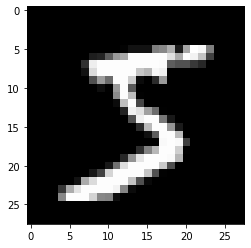

In [29]:
plt.imshow(np.squeeze(img0), 'gray')

# dataset에서 DataLoader를 구성
torch.utils.data.DataLoader는 학습할 때 데이터를 차례대로 또는 랜덤으로 선택하여 넘겨주는 역할  
train data와 valid data를 구분하여 학습용 데이터와 학습 상태를 검증하는 데이터로 사용  

In [32]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
# index를 shuffle
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]


In [34]:
train_index[:10], valid_index[:10], len(train_index), len(valid_index)

([43421, 16164, 27660, 43726, 29630, 15553, 55886, 17369, 24189, 3593],
 [44889, 56631, 25138, 38721, 13693, 41260, 33362, 9391, 40084, 34533],
 48000,
 12000)

In [35]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers)

# loader에서 한번의 배치만 읽어서 내용 확인
현재 batch_size를 20으로 지정한 상태임

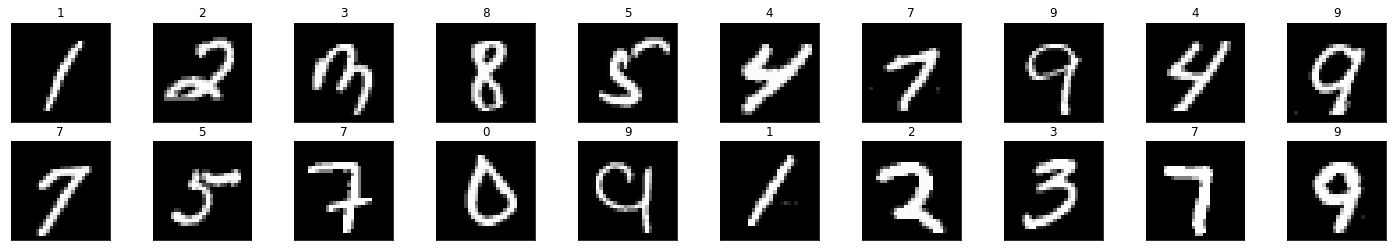

In [36]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

# 데이터 하나를 자세히 보기

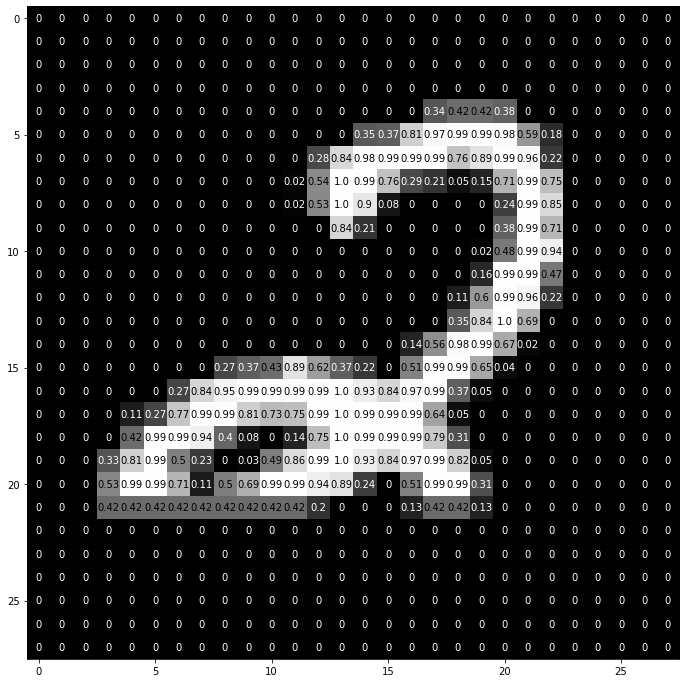

In [37]:
img = np.squeeze(images[1])
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

# fully connected layer 2개, 마지막 fully connected output layer가 1개인 Multilayer Perceptron 네트워크 정의
### PyTorch에서는 class method인 forward에서 forward propagation을 정의하면 backward propagation 부분은 자동으로 구성해 줌 (autograd 기능)

In [42]:
# define NN architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28*28, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512,512)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512,10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)
        
    def forward(self,x):
        # flatten image input. 20개의 28*28 크기의 3차원 입력데이터([20,28,28])인 x를 28*28(=784) 크기의 2차원 데이터로 변환([20,784]).
        # 여기서 정의한 MLP 네트워크에서는 2차원 정보를 이용하지 않음
        x = x.view(-1,28*28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
         # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x

In [43]:
# initialize the NN
model = MLP()
print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


model은 784 -> 512 -> 512 -> 10 의 구조를 가진 MLP

# Loss (Error)는 분류 문제에 사용하는 CrossEntropyLoss를 사용
# Gradient descent 알고리즘은 SGD(Stochastic Gradient Descent)를 사용
# Learning rate는 0.01

In [44]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

# 학습 실행
### n_epochs를 50으로 설정함
### 학습 1번 완료 후 train_data의 loss와 valid_data의 loss와 비교
### valid loss가 줄어들었으면 모델을 저장

In [45]:
# number of epochs to train the model
n_epochs = 50
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity
for epoch in range(n_epochs):
    # monitor losses
    train_loss = 0
    valid_loss = 0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data,label in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)
        
     ######################    
    # validate the model #
    ######################
    model.eval()  # prep model for evaluation
    for data,label in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # update running validation loss 
        valid_loss += loss.item() * data.size(0) # bug
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.920576 	Validation Loss: 0.384196
Validation loss decreased (inf --> 0.384196).  Saving model ...
Epoch: 2 	Training Loss: 0.351089 	Validation Loss: 0.296084
Validation loss decreased (0.384196 --> 0.296084).  Saving model ...
Epoch: 3 	Training Loss: 0.279784 	Validation Loss: 0.244276
Validation loss decreased (0.296084 --> 0.244276).  Saving model ...
Epoch: 4 	Training Loss: 0.228835 	Validation Loss: 0.207366
Validation loss decreased (0.244276 --> 0.207366).  Saving model ...
Epoch: 5 	Training Loss: 0.197122 	Validation Loss: 0.183295
Validation loss decreased (0.207366 --> 0.183295).  Saving model ...
Epoch: 6 	Training Loss: 0.170397 	Validation Loss: 0.163310
Validation loss decreased (0.183295 --> 0.163310).  Saving model ...
Epoch: 7 	Training Loss: 0.150329 	Validation Loss: 0.150302
Validation loss decreased (0.163310 --> 0.150302).  Saving model ...
Epoch: 8 	Training Loss: 0.135561 	Validation Loss: 0.138126
Validation loss decreased (0.15030

# 약 40 epoch 이후에는 valid loss가 줄어들지 않음

# 저장된 모델 로드

In [46]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

# test 데이터셋에 대해 인식률 계산

In [47]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval() # prep model for evaluation
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.060886

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 97% (1010/1032)
Test Accuracy of     3: 98% (996/1010)
Test Accuracy of     4: 98% (967/982)
Test Accuracy of     5: 97% (869/892)
Test Accuracy of     6: 98% (942/958)
Test Accuracy of     7: 97% (1003/1028)
Test Accuracy of     8: 97% (949/974)
Test Accuracy of     9: 97% (981/1009)

Test Accuracy (Overall): 98% (9813/10000)


# 약 98% 정확도 달성
# 실제 이미지를 보고 성능 확인
아래 예제에서는 하나의 미니배치(20개) 이미지를 확인함  

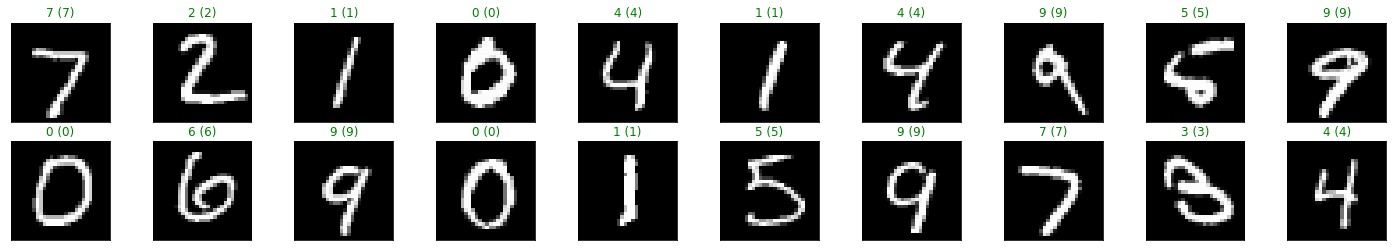

In [53]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
max_images = batch_size
for idx in np.arange(max_images):
    ax = fig.add_subplot(2, max_images/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

# 실습 종료